# <a id="title_ID"></a>
# JWST pipeline validation notebook for NIRCam imaging and grism TSO
### Instruments affected: NIRCam

<br>Prepared by Nikolay Nikolov
<br>Version 1

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) 
<br> [Introduction](#intro_ID) 
<br> [Step 1: Group Scale](#st1) 
<br> [Step 2: Data Quality (DQ) initialization](#st2) 
<br> [Step 3: Saturation Detection](#st3) 
<br> [Step 4: IPC Correction](#st4) 
<br> [Step 5: Superbias Subtraction](#st5) 
<br> [Step 6: Reference Pixel Correction](#st6) 
<br> [Step 7: Linearity Correction](#st7) 
<br> [Step 8: Persistence Correction](#st8) 
<br> [Step 9: Dark Current Subtraction ](#st9) 
<br> [Step 10: Jump Detection](#st10) 
<br> [Step 11: Ramp Fitting](#st11) 
<br> [Step 12: Gain Scale Correction](#st12) 
<br> [About This Notebook](#about_ID) 
<br>

</div>

<a id="imports_ID"></a>
# Imports

First, import libraries that will be used in this notebook.


* astropy.io for opening fits files
* numpy for array operations
* matplotlib.pyplot.plt for visualization purposes
* jwst pipeline

[Top of Page](#title_ID)

In [1]:
import astropy
import numpy as np
from astropy.io import fits
import math
import scipy
from scipy import stats

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

import jwst
import jwst.pipeline
import jwst.pipeline.calwebb_detector1
print("Pipeline version: ", jwst.__version__)

Pipeline version:  0.16.2


<a id="intro_ID"></a>
# Introduction

In this notebook we will run individual steps of CalWebb detector 1 processing on Mirage simulated transit to make sure the pipeline runs without a crash. We will also stop after most of the individual steps to check and compare results and make sure the pipeline performs as expected. Documentation of each step can be found on the readthedocs page of CalWebb here: https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html?highlight=stage%201

The data we will use consists of imaging and spectral time series generated with Mirage by Bryan Hilbert. The data sets consist of 350 frames of 5 groups with an injected transit signal. The data has been created using 5 dark samples, so the 1/f noise patter is requring more often in the time series, which could differ from reality. However, the data is great for technical tests, such as this one. We saved the data in two segments, so we will be testing if the pipeline works well with segmented data too.

Directory organization: 
<br> 1. We have placed the simulated imaging and TSgrism data in a directory called 'DATA'.
<br> 2. We create a directory called REFERENCE_FILES and will copy reference files to load and analyse during the analysis.
<br> 3. We also obtained all .cfg configuration files and use some of them to change thresholds, etc. These are specified thorughout the notebook. 
<br> 4. The results from each step will be stored in directories called: 'RESULTS_IMAGING' and 'RESULTS_SPECTROSCOPY'. These directories need to be created too.

To run each separate step, we will make use of the call() command. We also made the notebook able to run for both imaging and spectroscopy. Just select run_mode = 1 for imaging or 2 for spectroscopy in the next cell. For any issues, please reach out to me at nnikolov@stsci.edu 

[Top of Page](#title_ID)

In [2]:
# !!!!!!!!!!!!!!!!!!!!!
# Select the run mode:
run_mode = 2 
# !!!!!!!!!!!!!!!!!!!!!
# 1 - imaging 
# 2 - spectroscopy
# !!!!!!!!!!!!!!!!!!!!!



# Defining the data files
if run_mode == 1:
    files = ['../DATA/jw88888001001_01101_00001-seg001_nrca1_uncal.fits', 
             '../DATA/jw88888001001_01101_00001-seg002_nrca1_uncal.fits']
    results_dir = '../RESULTS_IMAGING'

if run_mode == 2:
    files   = ['../DATA/jw88888001001_01101_00002-seg001_nrca5_uncal.fits', 
               '../DATA/jw88888001001_01101_00002-seg002_nrca5_uncal.fits']
    results_dir = '../RESULTS_SPECTROSCOPY'


print(results_dir)

../RESULTS_SPECTROSCOPY


<a id="st1"></a>
# Step 1: Group Scale Correction

This step rescales pixel values in raw JWST science data products to correct for instances where on-board frame averaging did not result in the proper downlinked values. The step does not modify the pixel values of the SCI data, except that the pipeline adds three additional extentions (PIXELDQ, GROUPDQ and ERR) in the final products, which doesn't concern TSOs. 
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/group_scale/description.html

[Top of Page](#title_ID)

In [3]:
for i in range(len(files)):
    jwst.pipeline.calwebb_detector1.group_scale_step.GroupScaleStep.call(files[i], output_dir = results_dir, save_results = True)

2020-08-28 09:51:21,107 - CRDS - ERROR -  Error determining best reference for 'pars-groupscalestep'  =   Unknown reference type 'pars-groupscalestep'
2020-08-28 09:51:21,110 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2020-08-28 09:51:21,317 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args ('../DATA/jw88888001001_01101_00002-seg001_nrca5_uncal.fits',).
2020-08-28 09:51:21,319 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-28 09:51:22,248 - stpipe.GroupScaleStep - INFO - NFRAMES=1 is a power of 2; correction not needed
2020-08-28 09:51:22,248 - stpipe.GroupScaleStep - INFO - Step will be skipped
2020-08-28 09:51:25,313 - stpipe.GroupScaleStep - I

This cell runs without a crash, but produced an error from the CRDS (Calibration Reference Data System):
<br> *Error determining best reference for 'pars-groupscalestep'  =   Unknown reference type 'pars-groupscalestep'* 
<br> The reported error is produced by the CRDS and not by the CalWebb pipeline. We should therefore tread this message as a warning rather than an actual error and should ignore the message for this testing session.

Next, we will extract file root names to make the notebook capable of running all the TSO simulated data and to handle  both imaging and spectroscopy data sets.

In [4]:
froot = [files[i].replace('uncal.fits', '') for i in range(len(files))]
froot = [froot[i].replace('../DATA/', '') for i in range(len(froot))]
print(froot)

['jw88888001001_01101_00002-seg001_nrca5_', 'jw88888001001_01101_00002-seg002_nrca5_']


Load and list the headers and science pixel files for the uncalibrated and groupscaled fits files.

In [1959]:
# Load the Header Data Unit List for the uncalibrated fits files and from this step.
uncal_HDUL = fits.open(files[0])
print(uncal_HDUL.info())

gs_HDUL = fits.open(results_dir + '/' + froot[0] + 'groupscalestep.fits')
print(gs_HDUL.info())


Filename: ../DATA/jw88888001001_01101_00002-seg001_nrca5_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     120   ()      
  1  SCI           1 ImageHDU        50   (2048, 256, 5, 60)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 256, 60)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4343B]   


2020-08-27 23:02:11,454 - stpipe - WARNING - <ipython-input-1959-2670a5bb102c>:5: ResourceWarning: unclosed file <_io.FileIO name='../RESULTS_IMAGING/jw88888001001_01101_00001-seg001_nrca1_groupscalestep.fits' mode='rb' closefd=True>
  gs_HDUL = fits.open(results_dir + '/' + froot[0] + 'groupscalestep.fits')



None
Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [4891B]   
None



Let's load the SCI extentions and produce the difference to check for modiffications.


In [1960]:
uncal_sci = uncal_HDUL['SCI'].data
gs_sci    = gs_HDUL['SCI'].data

diff = uncal_sci - gs_sci

print(diff.shape)

(60, 5, 256, 2048)


In [1961]:
index = np.where(data_difference.flatten() == 0.)[0]
print('Total number of zeros:  ', len(index))
print('Total number of pixels: ', diff.shape[0]*diff.shape[1]*diff.shape[2]*diff.shape[3])

Total number of zeros:   157286400
Total number of pixels:  157286400


Indeed, nothing has changed in the pixel arrays. Let's print the difference of the uncalibrated and group scale corrected extensions to inspect the differences.

In [1962]:
results = fits.HeaderDiff(uncal_HDUL['PRIMARY'].header, gs_HDUL['PRIMARY'].header)
results.report()

" Headers have different number of cards:\n  a: 104\n  b: 108\n Extra keyword 'CAL_VCS' in b: 'RELEASE'\n Extra keyword 'CAL_VER' in b: '0.16.2'\n Extra keyword 'S_GRPSCL' in b: 'SKIPPED'\n Inconsistent duplicates of keyword ''      :\n  Occurs 8 time(s) in a, 9 times in (b)\n Keyword CHANNEL  has different comments:\n    a> NIRCam channel: long or short\n    b> Instrument channel\n Keyword DATE     has different values:\n    a> 2020-01-29T11:22:29.884\n    b> 2020-08-27T23:01:55.517\n Keyword DATE     has different comments:\n    a> [yyyy-mm-ddThh:mm:ss.ss] UTC date file cre\n    b> UTC date file created\n Keyword FILENAME has different values:\n    a> jw88888001001_01101_00002-seg001_nrca5_uncal.fits\n     ?                                         ^\n    b> jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits\n     ?                                        +++ ^^   +++++\n Keyword FILENAME has different comments:\n    a> Name of the file\n    b> Name of\n"

In [1963]:
results = fits.HeaderDiff(uncal_HDUL['SCI'].header, gs_HDUL['SCI'].header)
results.report()

" Headers have different number of cards:\n  a: 44\n  b: 42\n Extra keyword 'BSCALE' in a: 1\n Extra keyword 'BZERO'  in a: 32768\n Keyword BITPIX   has different values:\n    a> 16\n    b> -32\n Keyword DEC_REF  has different comments:\n    b> [deg] Declination of the reference point\n Keyword PC1_1    has different comments:\n    b> linear transformation matrix element\n Keyword PC1_2    has different comments:\n    b> linear transformation matrix element\n Keyword PC2_1    has different comments:\n    b> linear transformation matrix element\n Keyword PC2_2    has different comments:\n    b> linear transformation matrix element\n Keyword RA_REF   has different comments:\n    b> [deg] Right ascension of the reference point\n Keyword ROLL_REF has different comments:\n    a> [deg] Telescope roll angle of V3 measured from\n    b> [deg] V3 roll angle at the ref point (N over E)\n Keyword XREF_SCI has different comments:\n    a> Aperture X reference point in SCI frame from SI\n     ?      

In [1964]:
results = fits.HeaderDiff(uncal_HDUL['ZEROFRAME'].header, gs_HDUL['ZEROFRAME'].header)
results.report()

" Headers have different number of cards:\n  a: 12\n  b: 10\n Extra keyword 'BSCALE' in a: 1\n Extra keyword 'BZERO'  in a: 32768\n Keyword BITPIX   has different values:\n    a> 16\n    b> -32\n"

In [1965]:
results = fits.HeaderDiff(uncal_HDUL['GROUP'].header, gs_HDUL['GROUP'].header)
results.report()

''

In [1966]:
results = fits.HeaderDiff(uncal_HDUL['INT_TIMES'].header, gs_HDUL['INT_TIMES'].header)
results.report()

''

In [1967]:
results = fits.HeaderDiff(uncal_HDUL['ASDF'].header, gs_HDUL['ASDF'].header)
results.report()

' Keyword NAXIS1   has different values:\n    a> 4343\n    b> 4891\n Keyword TFORM1   has different values:\n    a> 4343B\n    b> 4891B\n'

In [1968]:
uncal_HDUL.close()
gs_HDUL.close()

<a id="st2"></a>
# Step 2: Data Quality (DQ) initialization

This step populates the DQ mask for the input dataset. Flag values from the appropriate static mask (“MASK”) reference file in CRDS are copied into the “PIXELDQ” array of the input dataset, because it is assumed that flags in the mask reference file pertain to problem conditions that affect all groups and integrations for a given pixel. We will run this on the product of the group scale step.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/dq_init/description.html

[Top of Page](#title_ID)

In [1969]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.dq_init_step.DQInitStep.call(results_dir + '/' + froot[i] + 'groupscalestep.fits', output_dir = results_dir, save_results = True)    

2020-08-27 23:02:22,000 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-08-27 23:02:22,001 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2020-08-27 23:02:22,272 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits',).
2020-08-27 23:02:22,274 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-27 23:02:23,888 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0038.fits
2020-08-27 23:02:31,727 - stpipe.DQInitStep - WARNING - Keyword NOISY does not correspond to an existing

This step ran without a crash. Again, we have the same CRDS error in determining the best reference for 'pars-dqinitstep', and a few other warnings:
<br> *Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored*

In [1970]:
# Load the Header Data Unit List from previous and this steps.
gs_HDUL = fits.open(results_dir + '/' + froot[0] + 'groupscalestep.fits' )
print(gs_HDUL.info())

dq_HDUL = fits.open(results_dir + '/' + froot[0] + 'dqinitstep.fits')
print(dq_HDUL.info())

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [4891B]   


2020-08-27 23:02:44,188 - stpipe - WARNING - <ipython-input-1970-e1c9cbece77d>:5: ResourceWarning: unclosed file <_io.FileIO name='../RESULTS_IMAGING/jw88888001001_01101_00001-seg001_nrca1_dqinitstep.fits' mode='rb' closefd=True>
  dq_HDUL = fits.open(results_dir + '/' + froot[0] + 'dqinitstep.fits')



None
Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_dqinitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5034B]   
None


Let's identify differences in the pixels after this step.

In [1971]:
gs_sci = gs_HDUL['SCI'].data
dq_sci = dq_HDUL['SCI'].data

diff = gs_sci - dq_sci

index = np.where(diff.flatten() == 0.)[0]
print('Total number of zeros:  ', len(index))
print('Total number of pixels: ', diff.shape[0]*diff.shape[1]*diff.shape[2]*diff.shape[3])


Total number of zeros:   157286400
Total number of pixels:  157286400


We will now print the header contents of the FITS files from the group scale and DQ to check for differences. We don't expect any modification of the SCI contents.

In [1972]:
results = fits.HeaderDiff(gs_HDUL['SCI'].header, dq_HDUL['SCI'].header)
results.report()

''

In [1973]:
results = fits.HeaderDiff(gs_HDUL['PRIMARY'].header, dq_HDUL['PRIMARY'].header)
results.report()

" Headers have different number of cards:\n  a: 108\n  b: 115\n Extra keyword 'CRDS_CTX' in b: 'jwst_0635.pmap'\n Extra keyword 'CRDS_VER' in b: '7.5.0.0'\n Extra keyword 'R_MASK' in b: 'crds://jwst_nircam_mask_0038.fits'\n Extra keyword 'S_DQINIT' in b: 'COMPLETE'\n Inconsistent duplicates of keyword ''      :\n  Occurs 9 time(s) in a, 12 times in (b)\n Keyword         [9] has different values:\n    a> Calibration step information\n    b> Reference file information\n Keyword DATE     has different values:\n    a> 2020-08-27T23:01:55.517\n    b> 2020-08-27T23:02:32.856\n Keyword FILENAME has different values:\n    a> jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits\n     ?                                        ^^^^^^^^^^\n    b> jw88888001001_01101_00002-seg001_nrca5_dqinitstep.fits\n     ?                                        ^^^^^^\n Keyword FILENAME has different comments:\n    a> Name of\n    b> Name of the\n     ?        ++++\n"

In [1974]:
results = fits.HeaderDiff(gs_HDUL['PIXELDQ'].header, dq_HDUL['PIXELDQ'].header)
results.report()

''

Let's check the masks for differences.

In [1975]:
diff = dq_HDUL['PIXELDQ'].data - gs_HDUL['PIXELDQ'].data

index = np.where(diff.flatten() == 0.)[0]

print('Total number of pixels in each integration: ', diff.shape[0]*diff.shape[1])
print('Total number of pixels did not change:      ', len(index))
print('Total number of pixels changed:              ', diff.shape[0]*diff.shape[1]-len(index))


Total number of pixels in each integration:  524288
Total number of pixels did not change:       511243
Total number of pixels changed:               13045


There are some identified pixels. Let's plot the subarrays to visually inspect which pixels are identified as problematic in the data and reference file.

<br> We include the reference files from this and each of the following steps in a directory called REFERENCE_FILES. To include the file in the directory, simply copy it using the console info from this step.

Filename: ../REFERENCE_FILES/jwst_nircam_mask_0038.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      89   ()      
  1  DQ            1 ImageHDU        13   (2048, 2048)   int32 (rescales to uint32)   
  2  DQ_DEF        1 BinTableHDU     20   13R x 4C   [J, J, 40A, 80A]   
  3  ASDF          1 NonstandardExtHDU     10   (2152,)      


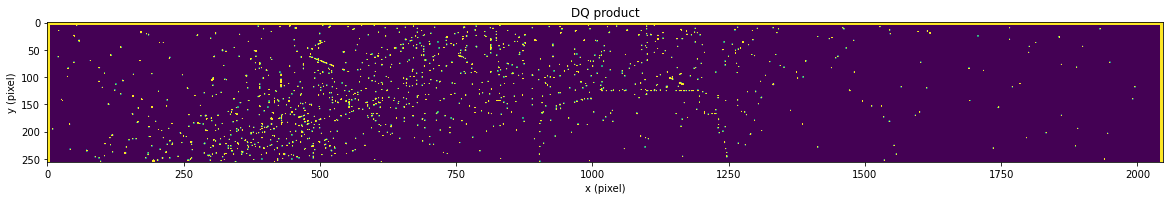

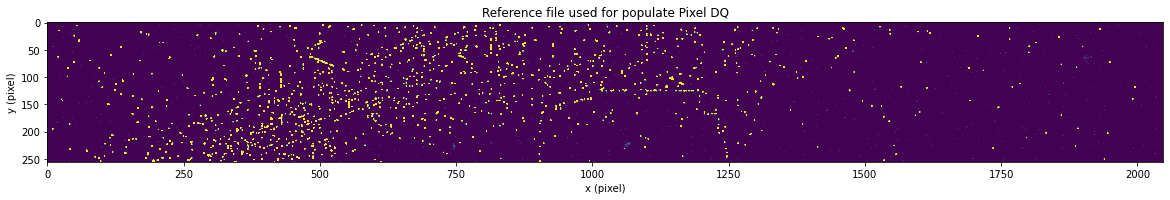

In [1976]:
if run_mode == 1:
    bp_mask_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_mask_0033.fits')
if run_mode == 2:
    bp_mask_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_mask_0038.fits')


bp_mask_HDUL.info()

dq_mask = dq_HDUL['PIXELDQ'].data
plt.figure(figsize=(20,10))
plt.title('DQ product')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(dq_HDUL['PIXELDQ'].data)
im.set_clim(0,2048)

plt.figure(figsize=(20,10))
plt.title('Reference file used for populate Pixel DQ')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(bp_mask_HDUL['DQ'].data[:-2048+256,:])
im.set_clim(0,2048)

bp_mask_HDUL.close()

The general picture is the same for both files. Now, let's have a closer look.

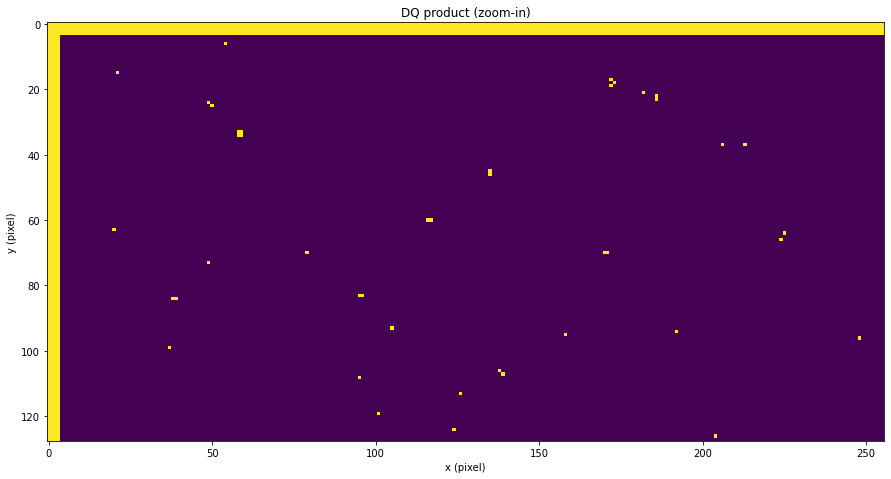

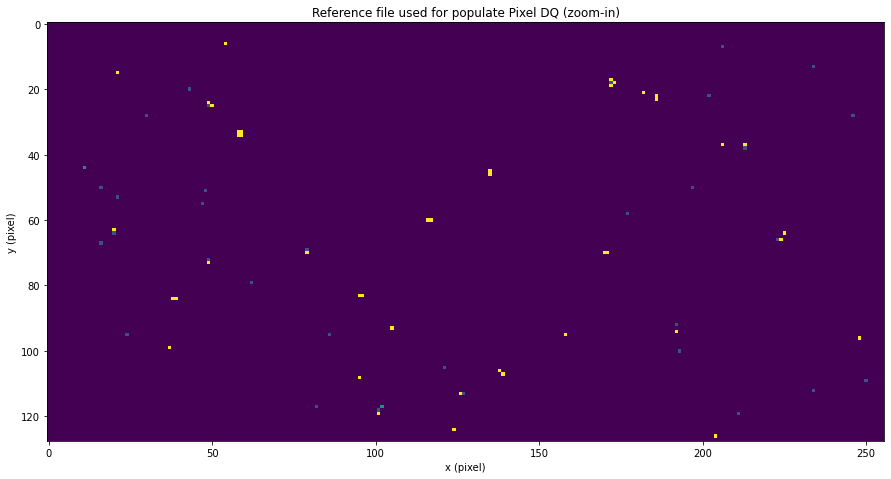

In [1977]:
mask_dq = dq_HDUL['PIXELDQ'].data
plt.figure(figsize=(15,15))
plt.title('DQ product (zoom-in)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(dq_HDUL['PIXELDQ'].data[0:128,0:256])
im.set_clim(0,2048*2)

plt.figure(figsize=(15,15))
plt.title('Reference file used for populate Pixel DQ (zoom-in)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(bp_mask_HDUL['DQ'].data[:-2048+128,0:256])
im.set_clim(0,2048*2)
bp_mask_HDUL.close()

We can see that most of the pixels from the reference file are propagated to the data, but not all. The reason for the extra pixels in the reference file, but not in the data is that the keywords NOISY and WEIRD were not identified.
<br>
<br>
Let's print lines to compare. Here is a link with the code for each value: https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/references_general.html#data-quality-flags
<br> 
<br> For example: 
<br> 0 is a bad pixel
<br> 1 is a saturated pixel
<br> 16384 is a RC pixel
<br> 2147483648 is a reference pixel
<br> 81920 = 65536 + 16384, where 65536 is a pixel highly nonlinear and 16384 is an RC pixel.
<br> 1025 = 1024 + 1, where 1024 is a Dead pixel and 1 is a Bad pixel


In [1978]:
a = dq_HDUL['PIXELDQ'].data[0:128,0:256]
b = bp_mask_HDUL['DQ'].data[:-2048+128,0:256]

line_id = 9

print(a[line_id, 4:].flatten())
print(b[line_id, 4:].flatten())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<a id="st3"></a>
# Step 3: Saturation Detection

This step step flags saturated pixel values. It loops over all integrations within an exposure, examining each one group-by-group, comparing the pixel values in the SCI array with defined saturation thresholds for each pixel. When it finds a pixel value in a given group that is above the threshold, it sets the “SATURATED” flag in the corresponding location of the “GROUPDQ” array in the science exposure. It also flags all subsequent groups for that pixel as saturated. For example, if there are 10 groups in an integration and group 7 is the first one to cross the saturation threshold for a given pixel, then groups 7 through 10 will all be flagged for that pixel.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/saturation/description.html

[Top of Page](#title_ID)

In [1979]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.saturation_step.SaturationStep.call(results_dir + '/' + froot[i] + 'dqinitstep.fits', output_dir = results_dir, save_results = True)    

2020-08-27 23:02:58,184 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-08-27 23:02:58,186 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2020-08-27 23:02:58,434 - stpipe.SaturationStep - INFO - Step SaturationStep running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_dqinitstep.fits',).
2020-08-27 23:02:58,436 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-27 23:02:59,469 - stpipe.SaturationStep - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nircam_saturation_0063.fits
2020-08-27 23:03:10,131 - stpipe.SaturationStep - WARNING - 

This step ran without a crash, except the CRDS error message. We also notice the following warnings:
<br> *Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword FEW_SAMPLES does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword AD_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword WEIRD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword DEAD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored*
<br> 
<br> Let's check the file info.

In [1980]:
print(gs_HDUL.info())

satur_HDUL = fits.open(results_dir + '/' + froot[0] + 'saturationstep.fits')
print(satur_HDUL.info())

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_groupscalestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   uint32   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [4891B]   


2020-08-27 23:03:19,971 - stpipe - WARNING - <ipython-input-1980-ca0ecf40275a>:3: ResourceWarning: unclosed file <_io.FileIO name='../RESULTS_IMAGING/jw88888001001_01101_00001-seg001_nrca1_saturationstep.fits' mode='rb' closefd=True>
  satur_HDUL = fits.open(results_dir + '/' + froot[0] + 'saturationstep.fits')



None
Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_saturationstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     144   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5126B]   
None


Print the total number of pixels and the number that changed.

In [1981]:
diff = satur_HDUL['GROUPDQ'].data - dq_HDUL['GROUPDQ'].data

index = np.where(diff.flatten() == 0.)[0]
print('Total number of pixels:                      ', diff.shape[0]*diff.shape[1]*diff.shape[2]*diff.shape[3])
print('Total number of pixels that did not change:  ', len(index))
print('Total number of pixels that did change:        ', diff.shape[0]*diff.shape[1]*diff.shape[2]*diff.shape[3] - len(index))

Total number of pixels:                       157286400
Total number of pixels that did not change:   154160211
Total number of pixels that did change:         3126189


Some pixels changed. Let's find the values of those. Again, we need to download the relevant reference files to a local directory.

In [1982]:
from jwst import datamodels
# Load the value for saturation
satur_flag = datamodels.dqflags.group['SATURATED']
print(satur_flag)

# Load the science extention of the saturation reference file; 
if run_mode == 1:
    rf_satur_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_saturation_0064.fits')
if run_mode == 2:
    rf_satur_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_saturation_0063.fits')

rf_satur_sci  = rf_satur_HDUL['SCI'].data[:-2048+256,:]

print(rf_satur_sci.shape)
rf_satur_HDUL.close()


# Loop a group of 5
for i in range(5):
    group_dq_flnt = satur_HDUL['GROUPDQ'].data[0,i,:,:].flatten()
    
    uncal_sci_flnt = uncal_HDUL['SCI'].data[0,i,:,:].flatten()
    rf_satur_sci_flnt = rf_satur_sci.flatten()
    
    index_satur = np.where(group_dq_flnt == satur_flag)[0]
    print('  ', len(index_satur),'saturated pixels in group ', i+1)
    print('     Uncal_sci - Ref_satur_sci: ', uncal_sci_flnt[index_satur] - rf_satur_sci_flnt[index_satur])


100*10421/(256*2048)

2
(256, 2048)
   10419 saturated pixels in group  1
     Uncal_sci - Ref_satur_sci:  [11409. 13536. 12781. ... 12247. 12346. 11318.]
   10421 saturated pixels in group  2
     Uncal_sci - Ref_satur_sci:  [11365. 13484. 12727. ... 12234. 12316. 11293.]
   10421 saturated pixels in group  3
     Uncal_sci - Ref_satur_sci:  [11356. 13477. 12714. ... 12219. 12307. 11278.]
   10422 saturated pixels in group  4
     Uncal_sci - Ref_satur_sci:  [11391. 13515. 12764. ... 12240. 12318. 11298.]
   10422 saturated pixels in group  5
     Uncal_sci - Ref_satur_sci:  [11378. 13502. 12735. ... 12215. 12296. 11279.]


1.9876480102539062

All of the masked pixels are greater than the saturation limit. We find ~2% of the pixels are saturated. 

<a id="st4"></a>
# Step 4: IPC Correction

The IPC step corrects a JWST exposure for interpixel capacitance by convolving with an IPC reference image. This step is skipped for NIRCam.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/ipc/description.html

[Top of Page](#title_ID)

<a id="st5"></a>
# Step 5: Superbias Subtraction

The superbias subtraction step removes the fixed detector bias from a science data set by subtracting a superbias reference image.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/superbias/description.html


[Top of Page](#title_ID)

In [1983]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.superbias_step.SuperBiasStep.call(results_dir + '/' + froot[i] + 'saturationstep.fits', output_dir = results_dir, save_results = True)    

2020-08-27 23:03:30,046 - CRDS - ERROR -  Error determining best reference for 'pars-superbiasstep'  =   Unknown reference type 'pars-superbiasstep'
2020-08-27 23:03:30,047 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2020-08-27 23:03:30,304 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_saturationstep.fits',).
2020-08-27 23:03:30,305 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-27 23:03:31,698 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nircam_superbias_0022.fits
2020-08-27 23:03:51,162 - stpipe.SuperBiasStep - WARNING - Keyword 

This step ran without a crash, except the CRDS error message. We also notice the following warnings:
<br> *Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored*

In [2021]:
# Load a superbias-subtracted image
sbias_HDUL = fits.open(results_dir + '/' + froot[0] + 'superbiasstep.fits')
print(sbias_HDUL.info())
sbias_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_superbiasstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     149   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5210B]   
None


This looks fine. Let's plot the superbias.

Filename: ../REFERENCE_FILES/jwst_nircam_superbias_0022.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  SCI           1 ImageHDU         8   (2048, 2048)   float32   
  2  DQ            1 ImageHDU        10   (2048, 2048)   float64   
  3  ERR           1 ImageHDU         8   (2048, 2048)   float32   
  4  DQ_DEF        1 BinTableHDU     17   7R x 4C   [J, J, 40A, 80A]   


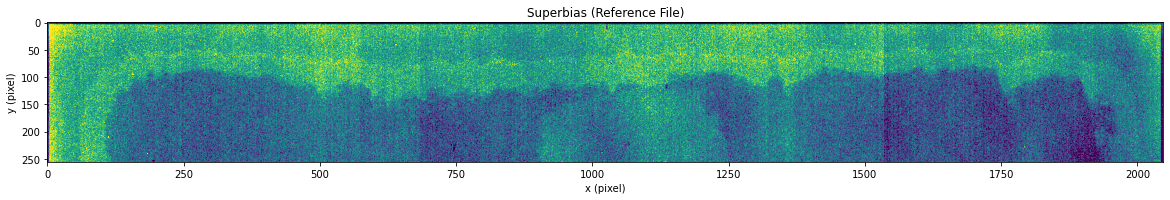

In [2108]:
# Load the superbias reference file;
if run_mode == 1:
    rf_sbias_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_superbias_0026.fits')
    rf_sbias_HDUL.info()

if run_mode == 2:
    rf_sbias_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_superbias_0022.fits')
    rf_sbias_HDUL.info()


# Take the array pixel values of the bias
rf_sbias_sci  = rf_sbias_HDUL['SCI'].data[:-2048+256,:]
rf_sbias_dq   = rf_sbias_HDUL['DQ'].data[:-2048+256,:]
#print(rf_sbias_sci.shape)
#print(rf_sbias_dq[0:20,100:120])




# Identify 'nan' values from the Superbias and set those to 0 for plotting
bool_ind = isnan(rf_sbias_sci)
ind_nan = np.where(bool_ind==True)
rf_sbias_sci[ind_nan[0],ind_nan[1]]=0.




im = rf_sbias_sci
im_mean  = np.mean(im)
im_stdev = np.std(im)

# Plot the bias
n_sig = 1
plt.figure(figsize=(20,10))
plt.title('Superbias (Reference File)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(rf_sbias_sci)
if run_mode == 1:
    im.set_clim(im_mean-n_sig*im_stdev,im_mean+n_sig*im_stdev)
if run_mode == 2:
    im.set_clim(100,3200)

#print(rf_sbias_sci)
rf_sbias_HDUL.close()

The white pixels on the Superbias are set to nans. These pixels are not used in the subtraction, but can be identified using the DQ extention of this file (values set to 513).

Filename: ../DATA/jw88888001001_01101_00002-seg001_nrca5_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     120   ()      
  1  SCI           1 ImageHDU        50   (2048, 256, 5, 60)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 256, 60)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4343B]   
None


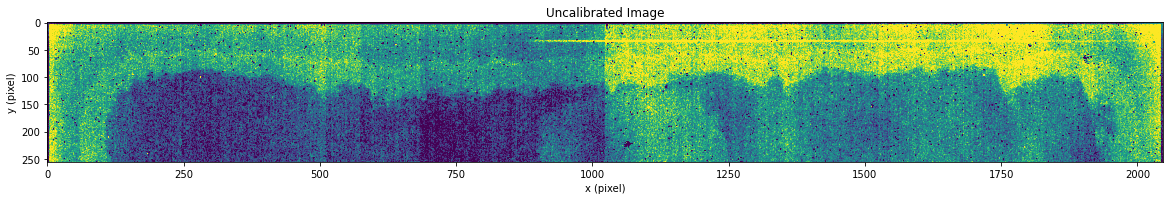

In [2109]:
# Load the science extention of an uncalibrated file
uncal_HDUL = fits.open(files[0])
print(uncal_HDUL.info())

# Take the array pixel values of the uncalibrated image
uncal_sci = uncal_HDUL['SCI'].data[0,4,:,:]
#print(uncal_sci)

# Replace nans with zeros
uncal_sci[ind_nan[0],ind_nan[1]]=0.

im = uncal_sci
im_mean  = np.mean(im)
im_stdev = np.std(im)


# Plot the uncalibrated image
n_sig = 1.0
plt.figure(figsize=(20,10))
plt.title('Uncalibrated Image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(uncal_sci)
im.set_clim(im_mean-n_sig*im_stdev,im_mean+n_sig*im_stdev)

uncal_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_superbiasstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     149   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5210B]   
None


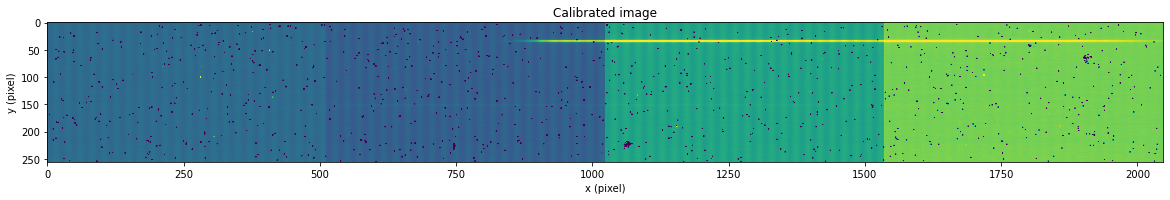

In [2114]:
# Load the science extention of a calibrated file
cal_HDUL = fits.open(results_dir + '/' + froot[0] + 'superbiasstep.fits')
print(cal_HDUL.info())

# Take the array pixel values of the calibrated image
cal_sci = cal_HDUL['SCI'].data[0,4,:,:]


# Replace nans with zeros
cal_sci[ind_nan[0],ind_nan[1]]=0.



im = cal_sci
if run_mode == 1:
    im = cal_sci[:,1900:2040]
im_mean  = np.mean(im)
im_stdev = np.std(im)

n_sig = 1.2

# Plot the calibrated image
plt.figure(figsize=(20,10))
plt.title('Calibrated image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(cal_sci)
im.set_clim(im_mean-n_sig*im_stdev,im_mean+n_sig*im_stdev)

cal_HDUL.close()

Let's reduce an uncalibrated image using the superbias.

(256, 2048)
(256, 2048)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


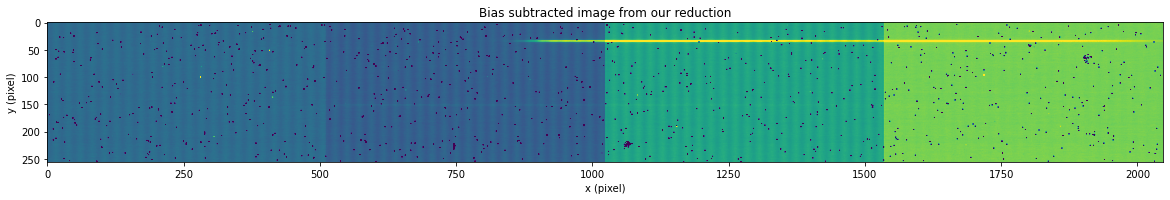

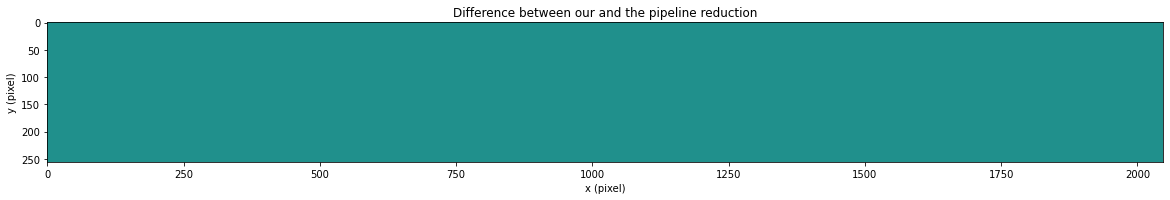

In [2116]:
# Reduce an uncalibrated image using the Masterbias
cal_nn = uncal_sci - rf_sbias_sci
print(cal_nn.shape)
print(rf_sbias_sci.shape)


im = cal_nn
if run_mode == 1:
    im = cal_nn[:,1900:2040]
im_mean  = np.mean(im)
im_stdev = np.std(im)


# Plot our calibrated image
plt.figure(figsize=(20,10))
plt.title('Bias subtracted image from our reduction')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(cal_nn)
im.set_clim(im_mean-n_sig*im_stdev,im_mean+n_sig*im_stdev)




# Plot the difference of our calibrated and the pipeline calibrated image
diff = cal_nn-cal_sci
print(diff)
plt.figure(figsize=(20,10))
plt.title('Difference between our and the pipeline reduction')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(diff)
if run_mode == 1:
    im.set_clim(-100,100)
if run_mode == 2:
    im.set_clim(-100,100)

The top plot shows our calibration with all nans from the Superbias set to 0 (black pixels). The lower plot shows the difference, which is 0 for all pixels, as expected.

In [2117]:
print(np.mean(diff), " mean")
print(np.min(diff), " min")
print(np.max(diff), " max")


0.0  mean
0.0  min
0.0  max


<a id="st6"></a>
# Step 6: Reference Pixel Correction

Pixel data from an ideal detector would contain only detected photons. However, real dtectors have electronic noises, some of which can be reduced using the data itself. This step uses uniluminated pixels on the sides of the full detector array (4-pixel wide strip along the edge columns and rows) to correct for detector noises, e.g. amplifier-dependent constant offset, 1/f noise, odd-even column and row effect. In the case of subarrays, half of the reference pixels (on the rows) are lost, so only four are used in this step. It is important to have the DQ initialization step ran before this one to make sure the PIXELDQ extention is populated with the reference pixel valuse, i.e. 2147483648.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/description.html

[Top of Page](#title_ID)

In [2005]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.refpix_step.RefPixStep.call(results_dir + '/' + froot[i] + 'superbiasstep.fits', config_file = '../refpix.cfg', output_dir = results_dir, save_results = True)   

2020-08-27 23:13:04,139 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   Unknown reference type 'pars-refpixstep'
2020-08-27 23:13:04,144 - stpipe.refpix - INFO - RefPixStep instance created.
2020-08-27 23:13:04,454 - stpipe.refpix - INFO - Step refpix running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_superbiasstep.fits',).
2020-08-27 23:13:04,456 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2020-08-27 23:13:05,376 - stpipe.refpix - INFO - use_side_ref_pixels = True
2020-08-27 23:13:05,376 - stpipe.refpix - INFO - odd_even_colu

This step ran without a crash or any issues.

In [6]:
# Load the Header Data Unit List from this step.
refpix_HDUL = fits.open(results_dir + '/' + froot[0] + 'refpixstep.fits')
print(refpix_HDUL.info())

refpix_sci = refpix_HDUL['SCI'].data[0,0,:,:]
refpix_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_refpixstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     150   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5229B]   
None


(256, 2048)
[[-416.07227  -238.86133  -386.09766  ...  132.61914  1001.0381
   147.56738 ]
 [-411.39453  -281.6377   -410.04785  ...   92.85547   989.0801
   112.31641 ]
 [-418.51172  -267.37305  -417.11426  ...  117.63965   963.25684
   100.97363 ]
 ...
 [-354.792    -247.1582   -385.59375  ...  149.63184   986.19727
   119.      ]
 [-399.708    -258.0244   -390.9297   ...   95.31152   990.7783
   106.052734]
 [-391.04395  -262.29785  -396.39355  ...   85.384766  983.1582
    92.65234 ]]


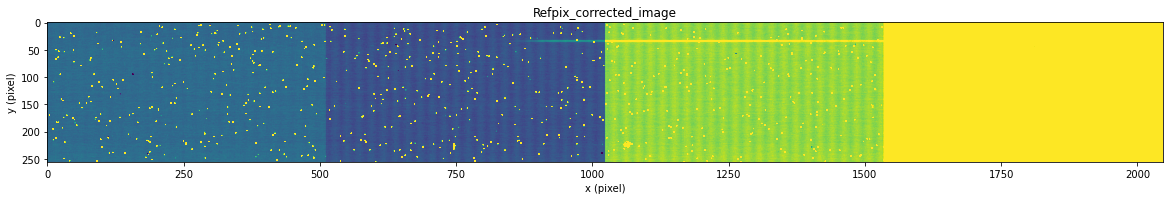

In [7]:
# Compute basic image stats
print(refpix_sci.shape)

im = refpix_sci

if run_mode == 1:
    im = refpix_sci[:,1750:2040]
    n_sig = 0.25
if run_mode == 2:
    n_sig = 0.3

im_min  = np.min(im)
im_max = np.max(im)
im_mean  = np.median(im)
im_stdev = np.std(im)

print(im)

plt.figure(figsize=(20,10))
plt.title('Refpix_corrected_image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(refpix_sci)
im.set_clim(im_mean-n_sig*im_stdev,im_mean+n_sig*im_stdev)
#im.set_clim(im_min,im_max)

In [8]:
# Load the science extention of an calibrated file from previous step
sb_HDUL = fits.open(results_dir + '/' + froot[0] + 'superbiasstep.fits')
print(sb_HDUL.info())

sb_sci = sb_HDUL['SCI'].data[0,0,:,:]
sb_pdq = sb_HDUL['PIXELDQ'].data

im = sb_pdq
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

print(im_min, 'min')
print(im_max, 'max')
print(im_mean, 'mean')
print(im_stdev, 'stdev')
print(im)

sb_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_superbiasstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     149   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5210B]   
None
0 min
2147483648 max
41839814.05692482 mean
296715364.8539715 stdev
[[2147483648 2147483648 2147483648 ... 2147483648 2147483648 2147483648]
 [2147483648 2147483648 21474

11326.139 min
12012.215 max
11669.183 mean
343.03796 stdev


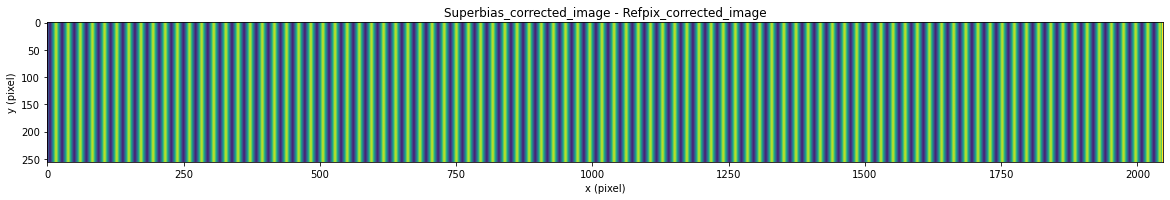

In [9]:
# Compute the difference image and basic stats
diff = sb_sci - refpix_sci

diff_min   = np.min(diff)
diff_max   = np.max(diff)
diff_mean  = np.mean(diff)
diff_stdev = np.std(diff)

print(diff_min, 'min')
print(diff_max, 'max')
print(diff_mean, 'mean')
print(diff_stdev, 'stdev')

n_sig = 0.1

# Plot the difference of this and the previous step
plt.figure(figsize=(20,10))
plt.title('Superbias_corrected_image - Refpix_corrected_image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(diff)
im.set_clim(diff_mean-n_sig*diff_stdev, diff_mean+n_sig*diff_stdev)

The difference image shows the reduction of constant value for each column, but it is puzzling that the amplifier offsets survive the step. This could be due to the rotation mentioned here: https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/description.html#overview

Let's make a quick test to see if using 4 of the reference pixels at the edge of each column would remove the amplifier imprints and the odd-even pattern. We will compute the mean or median of the edge 4 pixels and will remove that value from the entire column. We will plot one group before and after the correction.

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_refpixstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     150   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5229B]   
None
2048
(256, 2048)
Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_refpixstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  

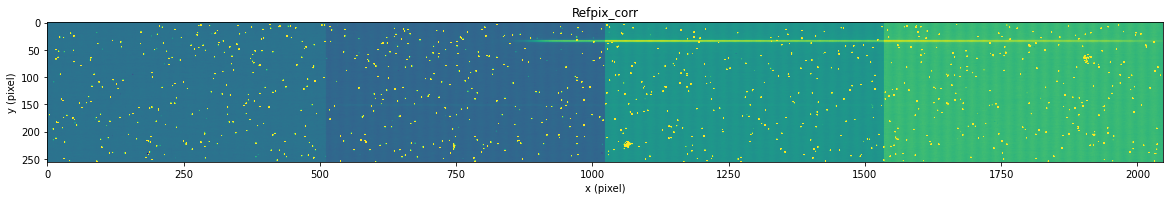

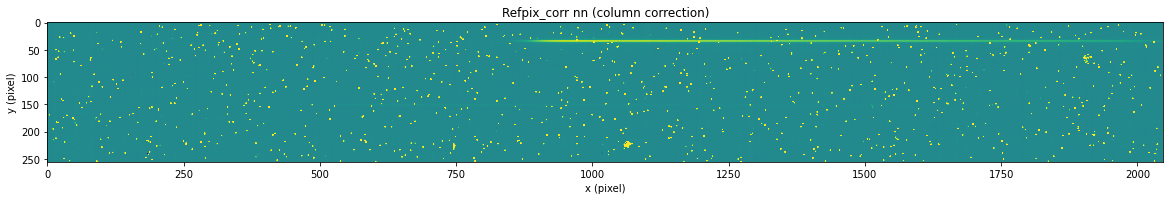

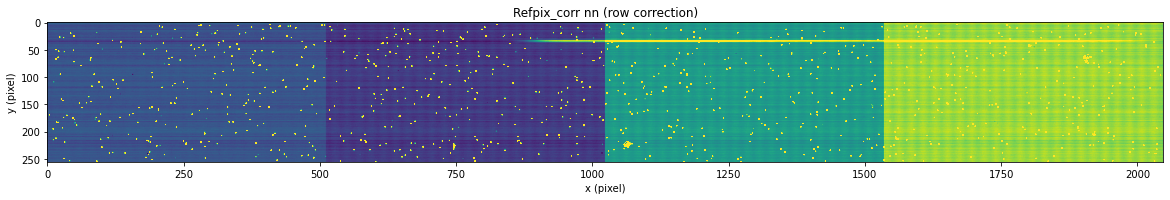

In [10]:
# Extract group 4 of integration 20
refpix_HDUL = fits.open(results_dir + '/' + froot[0] + 'refpixstep.fits')
print(refpix_HDUL.info())

refpix_sci_int20_gr4 = refpix_HDUL['SCI'].data[20,4,:,:]
refpix_HDUL.close()

n_sig1 = 1
n_sig2 = 0.5


im = refpix_sci_int20_gr4
if run_mode == 1:
    im = im[:,1750:2040]

print(im.shape[1])
print(im.shape)
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

# Plot the difference of this and the previous step
plt.figure(figsize=(20,10))
plt.title('Refpix_corr')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(refpix_sci_int20_gr4)
im.set_clim(im_mean-n_sig1*im_stdev, im_mean+n_sig1*im_stdev)






nc1 = 252
nc2 = 255

nc1 = 0
nc2 = 3

n_sig2 = 1
# Remove the column mean from 4 pixels
for j in range(refpix_sci_int20_gr4.shape[1]):
    mean = np.median(refpix_sci_int20_gr4[nc1:nc2,j])
    refpix_sci_int20_gr4[:,j] -= mean


im_mean  = np.mean(refpix_sci_int20_gr4)
im_stdev = np.std(refpix_sci_int20_gr4)
# Plot the difference of this and the previous step
plt.figure(figsize=(20,10))
plt.title('Refpix_corr nn (column correction)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(refpix_sci_int20_gr4)
im.set_clim(im_mean-n_sig2*im_stdev, im_mean+n_sig2*im_stdev)







# Extract group 4 of integration 20
refpix_HDUL = fits.open(results_dir + '/' + froot[0] + 'refpixstep.fits')
print(refpix_HDUL.info())

refpix_sci_int20_gr4 = refpix_HDUL['SCI'].data[20,4,:,:]
refpix_HDUL.close()

nc1 = 0
nc2 = 1000
n_sig2 = 0.5
# Remove the row mean from 4 pixels
for j in range(refpix_sci_int20_gr4.shape[0]):
    mean = np.mean(refpix_sci_int20_gr4[j,nc1:nc2])
    refpix_sci_int20_gr4[j,:] -= mean


# Plot the difference of this and the previous step
im = refpix_sci_int20_gr4
if run_mode == 1:
    im = im[:,1750:2040]

im_mean  = np.mean(im)
im_stdev = np.std(im)

plt.figure(figsize=(20,10))
plt.title('Refpix_corr nn (row correction)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(refpix_sci_int20_gr4)
im.set_clim(im_mean-n_sig2*im_stdev, im_mean+n_sig2*im_stdev)


We can see that even using the 4 pixels there is a substantial difference between the two. This implies the refpix step of CalWebb 7.5 is not doing much

<a id="st7"></a>
# Step 7: Linearity Correction

This step corrects for linearity. It is assumed that the input science exposure data for near-IR instruments have had the superbias subtraction step applied, therefore the correction coefficients stored in the linearity reference files for those instruments must have been derived from data that has also been bias subtracted.
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/linearity/description.html

[Top of Page](#title_ID)

In [11]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.linearity_step.LinearityStep.call(results_dir + '/' + froot[i] + 'refpixstep.fits', output_dir = results_dir, save_results = True)

2020-08-28 09:17:39,947 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   Unknown reference type 'pars-linearitystep'
2020-08-28 09:17:39,949 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2020-08-28 09:17:40,155 - stpipe.LinearityStep - INFO - Step LinearityStep running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_refpixstep.fits',).
2020-08-28 09:17:40,156 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-28 09:17:41,520 - stpipe.LinearityStep - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0052.fits
2020-08-28 09:18:19,840 - stpipe.LinearityStep - WARNING - Keyword UAZ_

This step ran without a crash, except the standard CRDS error message. In addition, we also notice the following warnings:
<br> 
<br> *Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored*
<br> 
<br> Let's check the files.

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_linearitystep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     155   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5317B]   
None
-12085.947 min
2204940.5 max
37.12969 mean
3380.6184 stdev


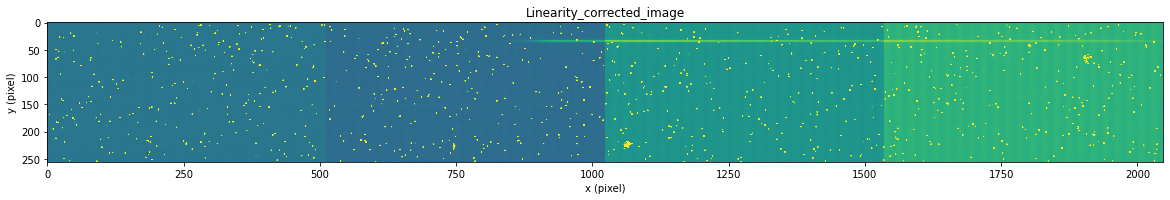

In [5]:
# Load the Header Data Unit List from this step.
lin_HDUL = fits.open(results_dir + '/' + froot[0] + 'linearitystep.fits')
print(lin_HDUL.info())

lin_sci = lin_HDUL['SCI'].data[19,3,:,:]

im = lin_sci
n_sig = 0.5
if run_mode == 1:
    im = im[:,1750:2040]
    n_sig = 1
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

print(im_min, 'min')
print(im_max, 'max')
print(im_mean, 'mean')
print(im_stdev, 'stdev')
#print(im)


# Plot the pipeline product
plt.figure(figsize=(20,10))
plt.title('Linearity_corrected_image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(lin_sci)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)
    

lin_HDUL.close()

In [17]:
# Load the science extention of the saturation reference file; 

if run_mode == 1:
    rf_lin_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_linearity_0056.fits')
    rf_lin_HDUL.info()
    print("echo1")
if run_mode == 2:
    rf_lin_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_linearity_0052.fits')
    rf_lin_HDUL.info()
    print("echo2")

# Take the array of linearity coefficients
rf_lin_coeffs  = rf_lin_HDUL['COEFFS'].data[:,:-2048+256,:]
rf_lin_dq      = rf_lin_HDUL['DQ'].data[:-2048+256,:]
print(rf_lin_coeffs.shape)
rf_lin_HDUL.close()

print(rf_lin_dq)


print(np.min(rf_lin_coeffs))
print(np.max(rf_lin_coeffs))
#print(stats.mode(rf_lin_coeffs))
#print(rf_lin_coeffs)

# # Identify 'nan' values from the reference file and set those to 0 for plotting
# bool_ind = np.isnan(rf_lin_coeffs)
# ind_nan = np.where(bool_ind==True)
# rf_lin_coeffs[ind_nan[0],ind_nan[1]]=0.
# #print(ind_nan[0])


Filename: ../REFERENCE_FILES/jwst_nircam_linearity_0052.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     102   ()      
  1  COEFFS        1 ImageHDU         9   (2048, 2048, 7)   float32   
  2  DQ            1 ImageHDU        10   (2048, 2048)   float64   
  3  DQ_DEF        1 BinTableHDU     17   10R x 4C   [J, J, 40A, 80A]   
echo2
(7, 256, 2048)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
nan
nan


We find that the coefficients for imaging data are zeros with some nans.

In [18]:
# Extract group 4 of integration 20
refpix_HDUL = fits.open(results_dir + '/' + froot[0] + 'refpixstep.fits')
print(refpix_HDUL.info())

refpix_sci_int20_gr4 = refpix_HDUL['SCI'].data[19,3,:,:]
refpix_HDUL.close()



# Define an empty array to store the result
lin_sci_nn = np.zeros(refpix_sci_int20_gr4.shape)
print(lin_sci_nn.shape)

for i in range(refpix_sci_int20_gr4.shape[0]):
    for j in range(refpix_sci_int20_gr4.shape[1]):
        lin_sci_nn[i,j] = np.polyval(rf_lin_coeffs[::-1,i,j], refpix_sci_int20_gr4[i,j])
#        print(rf_lin_coeffs[::-1,i,j])

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_refpixstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     150   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5229B]   
None
(256, 2048)


-1321.0347900390625 min
2204940.5 max
-23.43632042595152 mean
3084.096769214794 stdev


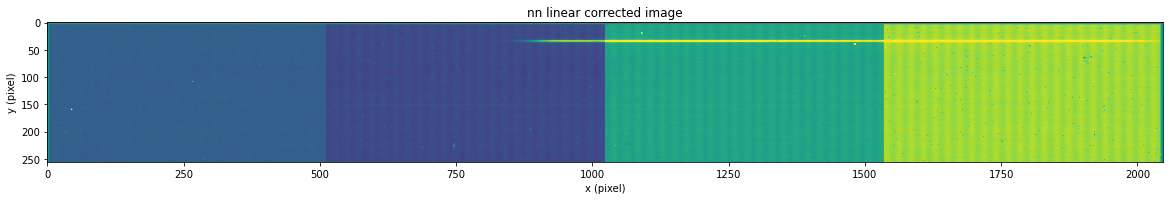

In [19]:
# Identify 'nan' values from the reference file and set those to 0 for plotting
bool_ind = np.isnan(lin_sci_nn)
ind_nan = np.where(bool_ind==True)
lin_sci_nn[ind_nan[0],ind_nan[1]]=0.
#print(ind_nan[0])

im = lin_sci_nn
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

print(im_min, 'min')
print(im_max, 'max')
print(im_mean, 'mean')
print(im_stdev, 'stdev')
#print(im)


n_sig = 0.25

# Plot the pipeline product
plt.figure(figsize=(20,10))
plt.title('nn linear corrected image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(lin_sci_nn)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

After removing the nans the reconstructed image looks similar to the pipeline product. Let's compute the difference between the pipeline product and our result.

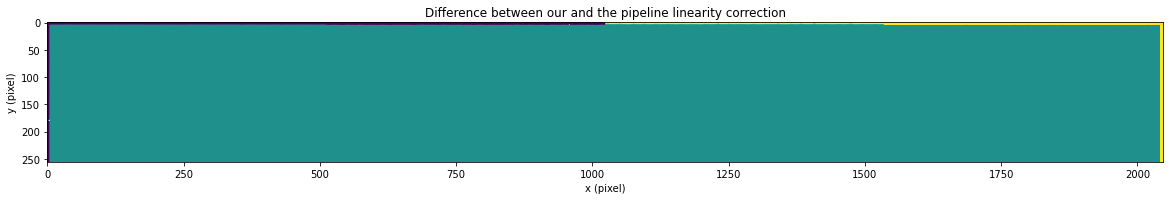

In [20]:
# Identify 'nan' values from the reference file and set those to 0 for plotting
#bool_ind = np.isnan(lin_sci)
#ind_nan = np.where(bool_ind==True)
lin_sci[ind_nan[0],ind_nan[1]]=0.
# #print(ind_nan[0])

diff = lin_sci - lin_sci_nn

# Plot the difference of our calibrated and the pipeline calibrated image
plt.figure(figsize=(20,10))
plt.title('Difference between the pipeline and our linearity correction')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(diff)
if run_mode == 1:
    im.set_clim(-100,100)
if run_mode == 2:
    im.set_clim(-100,100)

That is great. Most of the values are set to zero except in the reference pixel region, which is expected.

<a id="st8"></a>
# Step 8: Persistence Correction

This step is currently skipped for NIRCam
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/description.html

[Top of Page](#title_ID)

<a id="st9"></a>
# Step 9: Dark Current Subtraction 

This step subtracts a master dark reference file from all exposures of the time series. It is assumed that the input science data have NOT had the zero group (or bias) subtracted. 
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/dark_current/description.html

[Top of Page](#title_ID)

In [63]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.dark_current_step.DarkCurrentStep.call(results_dir + '/' + froot[i] + 'linearitystep.fits', output_dir = results_dir, save_results = True)   

2020-08-28 09:43:47,715 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   Unknown reference type 'pars-darkcurrentstep'
2020-08-28 09:43:47,717 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2020-08-28 09:43:47,856 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_linearitystep.fits',).
2020-08-28 09:43:47,857 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-08-28 09:43:49,244 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nircam_dark_0219.fits
2020-08-28 09:44:11,428 - stpipe.DarkCu

This step ran without a crash, except the CRDS error message. We also notice the following warnings:
<br> *Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored*
<br> *Keyword UNSTABLE_NOISE does not correspond to an existing DQ mnemonic, so will be ignored*

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_darkcurrentstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     160   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5393B]   
None
-10232.059 min
40312.85 max
38.693333 mean
1475.7758 stdev


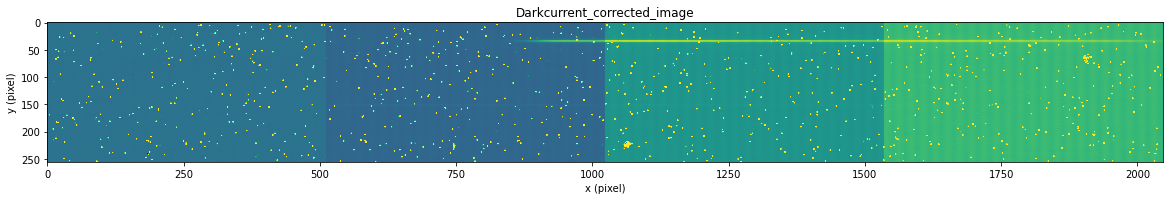

In [64]:
# Load the Header Data Unit List from this step.
dc_HDUL = fits.open(results_dir + '/' + froot[0] + 'darkcurrentstep.fits')
print(dc_HDUL.info())

dc_sci = dc_HDUL['SCI'].data[20,4,:,:]

im = dc_sci
if run_mode == 1:
    im = dc_sci[:,1900:2040]
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

print(im_min, 'min')
print(im_max, 'max')
print(im_mean, 'mean')
print(im_stdev, 'stdev')
#print(im)

n_sig = 1
# Plot the pipeline product
plt.figure(figsize=(20,10))
plt.title('Darkcurrent_corrected_image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(dc_sci)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)
    

dc_HDUL.close()

Filename: ../REFERENCE_FILES/jwst_nircam_dark_0219.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  SCI           1 ImageHDU        10   (2048, 256, 20)   float32   
  2  DQ            1 ImageHDU        11   (2048, 256)   int16 (rescales to uint16)   
  3  ERR           1 ImageHDU        10   (2048, 256, 20)   float32   
  4  DQ_DEF        1 BinTableHDU     18   7R x 4C   [J, J, 40A, 80A]   
(256, 2048)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


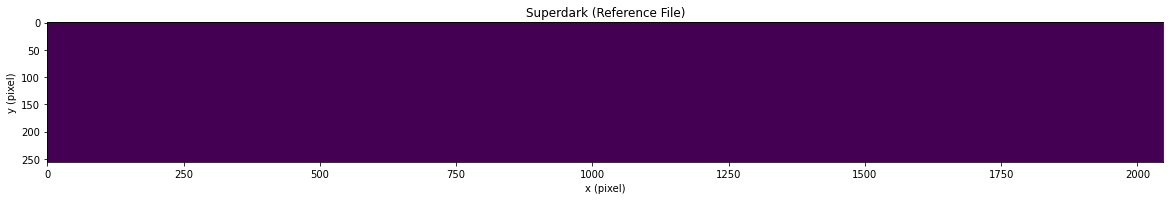

In [65]:
# Load the superdark reference file; 
if run_mode == 1:
    rf_dc_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_dark_0213.fits')
    rf_dc_HDUL.info()
if run_mode == 2:
    rf_dc_HDUL = fits.open('../REFERENCE_FILES/jwst_nircam_dark_0219.fits')
    rf_dc_HDUL.info()

# Take the array pixel values of the bias
#rf_dc_sci  = rf_dc_HDUL['SCI'].data[11,:,:]#[:-2048+256,:]
rf_dc_sci  = rf_dc_HDUL['SCI'].data[0,:,:]#[:-2048+256,:]
print(rf_dc_sci.shape)

print(rf_dc_sci)

# Plot the dark
im = rf_dc_sci
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

n_sig = 3
plt.figure(figsize=(20,10))
plt.title('Superdark (Reference File)')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(im)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

# Close the HDUL of the superdark
rf_dc_HDUL.close()

The dark image has zero values. That means a subtraction makes no difference.

<a id="st10"></a>
# Step 10: Jump Detection

This step detects jumps in an exposure by looking for outliers in the up-the-ramp signal for each pixel in each integration within an input exposure. 
<br> For more details: https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/description.html

[Top of Page](#title_ID)

In [66]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.jump_step.JumpStep.call(results_dir + '/' + froot[i] + 'darkcurrentstep.fits', output_dir = results_dir, save_results = True, config_file = '../jump.cfg')   

2020-08-28 09:44:51,269 - CRDS - ERROR -  Error determining best reference for 'pars-jumpstep'  =   Unknown reference type 'pars-jumpstep'
2020-08-28 09:44:51,273 - stpipe.jump - INFO - JumpStep instance created.
2020-08-28 09:44:51,469 - stpipe.jump - INFO - Step jump running with args ('../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_darkcurrentstep.fits',).
2020-08-28 09:44:51,471 - stpipe.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_SPECTROSCOPY', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 11.0, 'maximum_cores': None, 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}
2020-08-28 09:44:52,413 - stpipe.jump - INFO - CR rejection threshold = 11 sigma
2020-08-28 09:44:52,678 - stpipe.jump - INFO 

2020-08-28 09:45:29,891 - stpipe.jump - INFO - From highest outlier Two point found 88841 pixels with at least one CR
2020-08-28 09:45:32,257 - stpipe.jump - INFO -  working on integration 37
2020-08-28 09:45:32,397 - stpipe.jump - INFO - From highest outlier Two point found 1206 pixels with at least one CR
2020-08-28 09:45:32,442 - stpipe.jump - INFO -  working on integration 38
2020-08-28 09:45:32,573 - stpipe.jump - INFO - From highest outlier Two point found 1233 pixels with at least one CR
2020-08-28 09:45:32,618 - stpipe.jump - INFO -  working on integration 39
2020-08-28 09:45:32,741 - stpipe.jump - INFO - From highest outlier Two point found 60783 pixels with at least one CR
2020-08-28 09:45:34,337 - stpipe.jump - INFO -  working on integration 40
2020-08-28 09:45:34,457 - stpipe.jump - INFO - From highest outlier Two point found 387 pixels with at least one CR
2020-08-28 09:45:34,475 - stpipe.jump - INFO -  working on integration 41
2020-08-28 09:45:34,606 - stpipe.jump - INFO

2020-08-28 09:46:32,516 - stpipe.jump - INFO -  working on integration 10
2020-08-28 09:46:32,653 - stpipe.jump - INFO - From highest outlier Two point found 1263 pixels with at least one CR
2020-08-28 09:46:34,879 - stpipe.jump - INFO - Total elapsed time = 6.55865 sec
2020-08-28 09:46:34,888 - stpipe.jump - INFO - The execution time in seconds: 14.870438
2020-08-28 09:46:35,677 - stpipe.jump - INFO - Saved model in ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg002_nrca5_jump.fits
2020-08-28 09:46:35,677 - stpipe.jump - INFO - Step jump done


This step ran without a crash, except the CRDS error message. 

<br> It should be pointed out that the default value for threshold, which is used to detect cosmic rays (CRs) or other events adding more counts is low: rejection_threshold = 4.0 (sigma). This leads to detecting too many 'good' pixels. Setting this parameter in the configuration file to a higher value, e.g. rejection_threshold = 11.0 reduces the number of detections. To modify the rejection_threshold value, simply modify the jump.cfg file and provide the path to it in the call command, as indicated above. Thistest is performed with rejection_threshold = 11.0.

In [67]:
# Load the Header Data Unit List from this step.
jump_HDUL = fits.open(results_dir + '/' + froot[0] + 'jump.fits')
print(jump_HDUL.info())

jump_sci = jump_HDUL['SCI'].data[20,4,:,:]
jump_HDUL.close()


Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_jump.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5516B]   
None


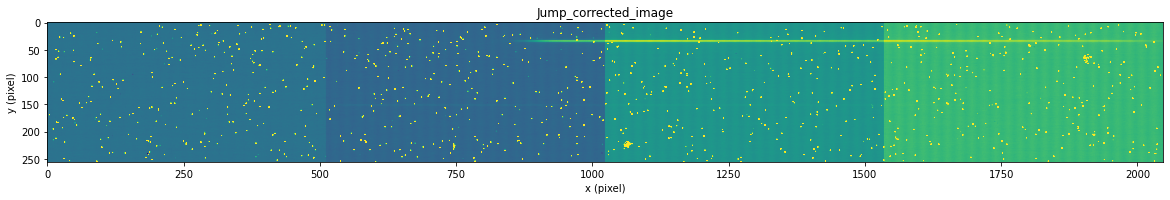

In [68]:
im = jump_sci
if run_mode == 1:
    im = jump_sci[:,1900:2040]
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

# print(im_min, 'min')
# print(im_max, 'max')
# print(im_mean, 'mean')
# print(im_stdev, 'stdev')
#print(im)

n_sig = 1
# Plot the pipeline product
plt.figure(figsize=(20,10))
plt.title('Jump_corrected_image')
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(jump_sci)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

This looks identical to the previous step. Let's check the identified pixels.

In [69]:
# Load the Header Data Unit List from this step.
gp  = 1
exp = 3

jump_HDUL = fits.open(results_dir + '/' + froot[0] + 'jump.fits')
print(jump_HDUL.info())
jump_gdq = jump_HDUL['GROUPDQ'].data[exp,gp,:,:]
jump_HDUL.close()

dc_HDUL = fits.open(results_dir + '/' + froot[0] + 'darkcurrentstep.fits')
print(dc_HDUL.info())
dc_gdq = dc_HDUL['GROUPDQ'].data[exp,gp,:,:]
dc_HDUL.close()

diff = jump_gdq - dc_gdq
print(diff)

index_jump = np.where(diff != 0)
print(len(index_jump[0]))


Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_jump.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5516B]   
None
Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_darkcurrentstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 Pr

We detected only a few thouand jumps, which is reasonable given the higher threshold.

<a id="st11"></a>
# Step 11: Ramp Fitting

This step determines the mean count rate, in units of counts per second, for each pixel by performing an ordinary least squares (OLS) fit to the data. The fit is performed independently for each pixel.
<br> Link to description: https://jwst-pipeline.readthedocs.io/en/stable/jwst/ramp_fitting/description.html

[Top of Page](#title_ID)

In [1942]:
for i in range(len(froot)):
    jwst.pipeline.calwebb_detector1.ramp_fit_step.RampFitStep.call(results_dir + '/' + froot[i] + 'jump.fits', config_file = '../ramp_fit.cfg', output_dir = results_dir, save_results = True)   

2020-08-27 22:51:09,423 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   Unknown reference type 'pars-rampfitstep'
2020-08-27 22:51:09,427 - stpipe.RampFit - INFO - RampFitStep instance created.
2020-08-27 22:51:09,679 - stpipe.RampFit - INFO - Step RampFit running with args ('../RESULTS_IMAGING/jw88888001001_01101_00001-seg001_nrca1_jump.fits',).
2020-08-27 22:51:09,681 - stpipe.RampFit - INFO - Step RampFit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_IMAGING', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': ''}
2020-08-27 22:51:10,938 - stpipe.RampFit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nircam_readnoise_0025.fits
2020-08-27 22:51:11,012 - stpipe.RampFit - INFO - Using GAIN reference file: 

This step ran without a crash, except the CRDS error message. 

In [2015]:
# Load the Header Data Unit List from this step.
ramp_HDUL = fits.open(results_dir + '/' + froot[0] + '1_rampfit.fits')
print(ramp_HDUL.info())

ramp_sci = ramp_HDUL['SCI'].data[:,:,:]
ramp_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_1_rampfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     145   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 60)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 60)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 60)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 60)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 60)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4608B]   
None


-315.56607 min
28028.068 max
2.7865598 mean
52.542805 stdev


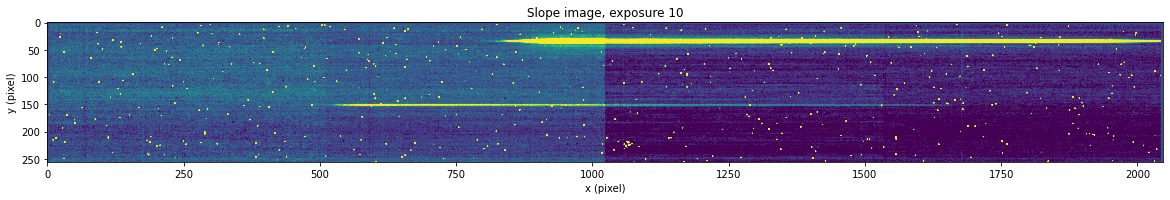

In [2016]:
im = ramp_sci
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)

print(im_min, 'min')
print(im_max, 'max')
print(im_mean, 'mean')
print(im_stdev, 'stdev')
# print(im)


# Plot the pipeline product

exp_id = 10
n_sig = 0.1

if run_mode == 1:
    n_sig = 0.15

plt.figure(figsize=(20,10))
plt.title('Slope image, exposure ' + str(exp_id) )
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(im[exp_id-1,:,:])
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

This image reveals several of the NIRCam detector characteristics including amplifier (output) background and 1/f noise, which is manifested as horizontal bands crossing the entire detector. 
<br>
<br> Let's compute the slopes ourselves and compare to the pipeline products.

In [2017]:
# Define exposure and group id to work with.
exp_id = 10

# Load the Header Data Unit List from the previous step.
jump_HDUL = fits.open(results_dir + '/' + froot[0] + 'jump.fits')
print(jump_HDUL.info())

jump_sci_gps = jump_HDUL['SCI'].data[exp_id-1,:,:,:]
print(jump_sci_gps.shape)
jump_pdq = jump_HDUL['PIXELDQ'].data
jump_HDUL.close()

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_jump.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 5, 60)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 5, 60)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 5, 60)   float32   
  5  ZEROFRAME     1 ImageHDU        10   (2048, 256, 60)   float32   
  6  GROUP         1 BinTableHDU     36   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  7  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [5516B]   
None
(5, 256, 2048)


In [2018]:
print(jump_sci_gps.shape[0])
print(jump_sci_gps.shape[1])
print(jump_sci_gps.shape[2])

# Define an empty array to store the results from the slope fitting
nn_slopes = np.zeros(jump_pdq.shape)
print(my_slopes.shape)

for i in range(jump_sci_gps.shape[1]):
    for j in range(jump_sci_gps.shape[2]):
        x=arange(5)
        y=jump_sci_gps[:,i,j]
        res = np.polyfit(x, y, 1, rcond=None, full=False, w=None, cov=False)
        nn_slopes[i,j] = res[0]

5
256
2048
(256, 2048)


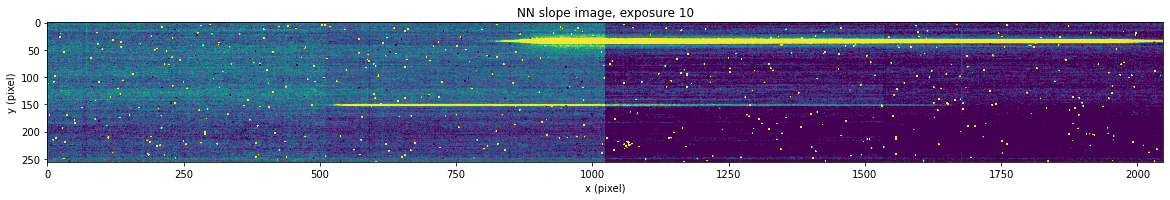

In [2019]:
# Plot the product from our slope fitting
n_sig = 0.1

plt.figure(figsize=(20,10))
plt.title('NN slope image, exposure ' + str(exp_id) )
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(nn_slopes)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

Our slope image looks different compared to the pipeline product. Let's take the difference of the two.

Filename: ../RESULTS_SPECTROSCOPY/jw88888001001_01101_00002-seg001_nrca5_1_rampfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     145   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 60)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 60)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 60)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   70R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 60)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 60)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4608B]   
None
0


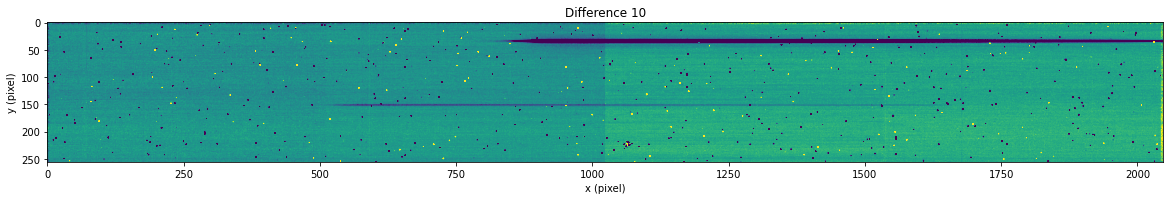

In [2020]:
# Load the Header Data Unit List from this step.
ramp_HDUL = fits.open(results_dir + '/' + froot[0] + '1_rampfit.fits')
print(ramp_HDUL.info())

ramp_sci = ramp_HDUL['SCI'].data[exp_id-1,:,:]
ramp_HDUL.close()



diff = ramp_sci-nn_slopes

index_zeros = np.where(diff == 0)
print(len(index_zeros[0]))
#print(diff)

im = diff
im_min   = np.min(im)
im_max   = np.max(im)
im_mean  = np.mean(im)
im_stdev = np.std(im)
# Plot the difference
n_sig = 0.1

plt.figure(figsize=(20,10))
plt.title('Difference ' + str(exp_id) )
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
im = plt.imshow(diff)
im.set_clim(im_mean-n_sig*im_stdev, im_mean+n_sig*im_stdev)

There is a significsnt resisidual image. The slope image from the pipeline is using flagged pixels from the jump step and fits different segments in groups with detected CRs or other jumps. The final slope is a weighted mean from the two, which make it different from our approach. In our fits, we performed least squares without taking into account weights. Currently, the call() command doesn't allow to run the pipelne with unweighted slopes, but in the future it would be necessary to compare the two outputs.

<a id="st12"></a>
# Step 12: Gain Scale Correction

The gain_scale step rescales pixel values in JWST countrate science data products in order to correct for the effect of using a non-standard detector gain setting. This step applies only to NIRSpec.

[Top of Page](#title_ID)

In [1954]:
for i in range(len(froot)):
    for j in range(2):
        jwst.pipeline.calwebb_detector1.gain_scale_step.GainScaleStep.call(results_dir + '/' + froot[i] + str(j) + '_rampfit.fits', output_dir = results_dir, save_results = True)   


2020-08-27 23:00:03,719 - CRDS - ERROR -  Error determining best reference for 'pars-gainscalestep'  =   Unknown reference type 'pars-gainscalestep'
2020-08-27 23:00:03,721 - stpipe.GainScaleStep - INFO - GainScaleStep instance created.
2020-08-27 23:00:03,853 - stpipe.GainScaleStep - INFO - Step GainScaleStep running with args ('../RESULTS_IMAGING/jw88888001001_01101_00001-seg001_nrca1_0_rampfit.fits',).
2020-08-27 23:00:03,855 - stpipe.GainScaleStep - INFO - Step GainScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '../RESULTS_IMAGING', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-27 23:00:04,629 - stpipe.GainScaleStep - INFO - GAINFACT not found in gain reference file
2020-08-27 23:00:04,630 - stpipe.GainScaleStep - INFO - Step will be skipped
2020-08-27 23:00:04,744 - stpipe.GainScaleStep - INFO - Sa

This step ran without a crash and it was indeed skipped. We note the CRDS error message. 

<a id="about_ID"></a>
## About this Notebook
**Author:** Nikolay Nikolov, Associate Scientist, NIRCam
<br>**Updated On:** 07/31/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 